# Training a logistic regression with simulated data of a wind-turbine


In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import random



In [20]:
def wind_turbine_model(x):

    # cut-in pseed vs cut-out speed
    if x<4.5 or x>21.5:
        return 0.0

    # standard operability
    return 376.936 - 195.8161*x + 33.75734*x**2 - 2.212492*x**3 + 0.06309095*x**4 - 0.0006533647*x**5

## Generating simulated data

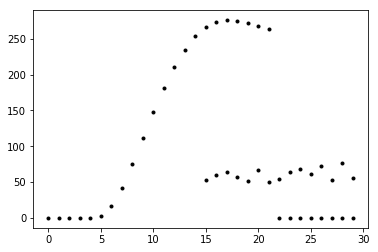

In [21]:
X_train=[]
y_train=[]


X_train.extend( [[x ,wind_turbine_model(x)] for x in range(0,30)] )
y_train.extend( [1 for x in range(0,30)] )


for x in range(15,30):
    X_train.extend([[x, 50 + x*random.random()]])
    y_train.extend([0])

import matplotlib.pyplot as plt
plt.plot([x[0] for x in X_train],[x[1] for x in X_train],'.k')

In [4]:
print(X_train)
print(y_train)

[[0, 0.0], [1, 0.0], [2, 0.0], [3, 0.0], [4, 0.0], [5, 2.6175790624998556], [6, 16.090675292799844], [7, 41.94847443709993], [8, 75.0921327103998], [9, 111.38816277969987], [10, 147.59002999999967], [11, 181.2597486502996], [12, 210.68947816959945], [13, 234.8231193929003], [14, 253.17791078719978], [15, 265.7660246874989], [16, 273.0161635327993], [17, 275.6951561020994], [18, 274.82955375039955], [19, 271.6272266446979], [20, 267.3989599999991], [21, 263.48005031529874], [22, 0.0], [23, 0.0], [24, 0.0], [25, 0.0], [26, 0.0], [27, 0.0], [28, 0.0], [29, 0.0], [15, 54.014612200956535], [16, 58.450935861402776], [17, 58.671366084803005], [18, 53.841196477191815], [19, 54.50794086257714], [20, 52.971010233116395], [21, 56.14662221707792], [22, 59.7389265748589], [23, 53.2531739501503], [24, 57.440450342382476], [25, 53.657537464394785], [26, 56.376831083751846], [27, 67.18676812156161], [28, 59.56875816930078], [29, 62.32376498288529]]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

## Train the model

In [5]:
logreg = LogisticRegression(random_state=0, solver='lbfgs',
...                          multi_class='multinomial')
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [6]:
test=logreg.predict([[16,wind_turbine_model(16)],[1,wind_turbine_model(1)],[25,wind_turbine_model(25)],[25,50],[18,250]])

In [7]:
print(test)

import numpy as np
# calculate accuracy on the prediction
acc = np.average(test == [1,1,1,0,1])
print('Accuracy is', acc)

[1 1 0 0 1]
Accuracy is 0.8


## Deploy on the azure cloud
change the subscription_id with your Azure subscription id (see https://ms.portal.azure.com/#blade/Microsoft_Azure_Billing/SubscriptionsBlade)

In [8]:
subscription_id='<the subscription>'

In [9]:
import azureml.core
print(azureml.core.VERSION)

from azureml.core import Workspace

# create
ws = Workspace.create(name='iiot-book-ml-workspace02',
                      subscription_id=subscription_id,
                      resource_group='iiot-book-res',
                      create_resource_group=True,
                      location='westeurope' # or other supported Azure region
                     )
#ws = Workspace.from_config()

# store information on the configuration file.
ws.write_config()

from azureml.core import Experiment

# create a new experiment
exp = Experiment(workspace=ws, name='wind-turbine-experiment')




/Users/giacomoveneri/Documents/workspace-iiot/exp/python-azure/env/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.24) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


0.1.68
Wrote the config file config.json to: /Users/giacomoveneri/Documents/workspace-iiot/exp/python-azure/aml_config/config.json


## Prepare the cluster

In [10]:
# compute target
from azureml.core.compute import ComputeTarget, BatchAiCompute
from azureml.core.compute_target import ComputeTargetException

# choose a name for your cluster
batchai_cluster_name = "traincluster-w3"

try:
    # look for the existing cluster by name
    compute_target = ComputeTarget(workspace=ws, name=batchai_cluster_name)
    if type(compute_target) is BatchAiCompute:
        print('found compute target {}, just use it.'.format(batchai_cluster_name))
    else:
        print('{} exists but it is not a Batch AI cluster. Please choose a different name.'.format(batchai_cluster_name))
except ComputeTargetException:
    print('creating a new compute target...')
    compute_config = BatchAiCompute.provisioning_configuration(vm_size="STANDARD_D2_V2", # small CPU-based VM
                                                                #vm_priority='lowpriority', # optional
                                                                autoscale_enabled=True,
                                                                cluster_min_nodes=0, 
                                                                cluster_max_nodes=2)

    # create the cluster
    compute_target = ComputeTarget.create(ws, batchai_cluster_name, compute_config)

    # can poll for a minimum number of nodes and for a specific timeout. 
    # if no min node count is provided it uses the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

    # Use the 'status' property to get a detailed status for the current cluster. 
    print(compute_target.status.serialize())

creating a new compute target...
Creating
succeeded
BatchAI wait for completion finished
Minimum number of nodes requested have been provisioned
{'allocationState': 'steady', 'allocationStateTransitionTime': '2018-10-19T16:34:41.110000+00:00', 'creationTime': '2018-10-19T16:34:31.333000+00:00', 'currentNodeCount': 0, 'errors': None, 'nodeStateCounts': {'idleNodeCount': 0, 'leavingNodeCount': 0, 'preparingNodeCount': 0, 'runningNodeCount': 0, 'unusableNodeCount': 0}, 'provisioningState': 'succeeded', 'provisioningStateTransitionTime': '2018-10-19T16:34:40.614000+00:00', 'scaleSettings': {'manual': None, 'autoScale': {'maximumNodeCount': 2, 'minimumNodeCount': 0, 'initialNodeCount': 0}}, 'vmPriority': 'dedicated', 'vmSize': 'STANDARD_D2_V2'}


## Build eth estimator

In [15]:
import os
script_folder = './wind_turbine_logreg'
os.makedirs(script_folder, exist_ok=True)

from azureml.train.estimator import Estimator

ds = ws.get_default_datastore()
print(ds.datastore_type, ds.account_name, ds.container_name)

ds.upload(src_dir='./data', target_path='data', overwrite=True, show_progress=True)

script_params = {
    '--data-folder': ds.as_mount(),
    '--regularization': 0.8
}

est = Estimator(source_directory=script_folder,
                script_params=script_params,
                compute_target=compute_target,
                entry_script='train.py',
                conda_packages=['scikit-learn'])

run = exp.submit(config=est)
run

AzureFile iiotbookstoragekxngzrwr azureml-filestore-bb2927ff-69c9-4e27-8d8e-d5329f802f91


Experiment,Id,Type,Status,Details Page,Docs Page
wind-turbine-experiment,wind-turbine-experiment_1539968489027,azureml.scriptrun,Running,Link to Azure Portal,Link to Documentation


# Clean ALL

In [17]:
# optionally, delete the Azure Managed Compute cluster
compute_target.delete()

In [18]:

ws.delete(delete_dependent_resources=True)